In [1]:
gpus = [1]
import os
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *
from utils import *
from scipy.spatial import distance
import seaborn as sns
import umap

In [2]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [4]:
morph_folder = os.path.abspath('/mnt/cube/kai/repositories/morphs/data/stimuli')

results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/morph')
spec_file = os.path.join(morph_folder, 'specs_star.p')

# load all dfs

In [88]:
all_pred = pickle.load(open(os.path.join(results_folder, 'extended', 'all_predicted.p'), 'rb'))
group1_behav = pickle.load(open(os.path.join(results_folder, 'group1_behav_agg.p'), 'rb'))
group2_behav = pickle.load(open(os.path.join(results_folder, 'group2_behav_agg.p'), 'rb'))
group3_behav = pickle.load(open(os.path.join(results_folder, 'group3_behav_agg.p'), 'rb'))

In [89]:
all_groups = pd.concat([all_pred,
                       group1_behav, group2_behav, group3_behav]).reset_index(drop=True)

In [90]:
all_groups.head()

,index,min_val,max_val,slope,inflection,group,metric
0,af,1.000000e-16,0.958480,0.021558,61.000512,Group 1,rmse
1,ag,1.000000e-16,0.976493,0.029138,52.000103,Group 1,rmse
2,ah,1.500527e-01,0.802789,0.032490,54.001817,Group 1,rmse
3,be,1.535884e-01,1.000000,0.046353,87.584029,Group 1,rmse
4,bf,1.958787e-01,0.981050,0.042703,92.274811,Group 1,rmse


(0.0, 1.0)

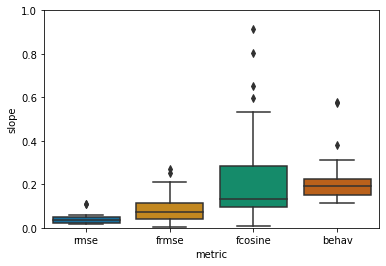

In [91]:
ax = sns.boxplot(y='slope', x='metric',data=all_groups)
ax.set_ylim([0,1])

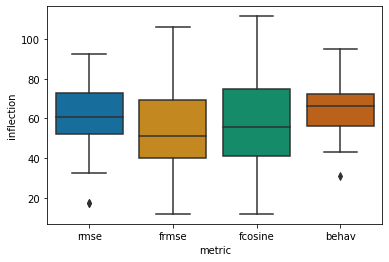

In [92]:
ax = sns.boxplot(y='inflection', x='metric',data=all_groups)

# separate by group

In [93]:
groups = ['Group 1', 'Group 2', 'Group 3']

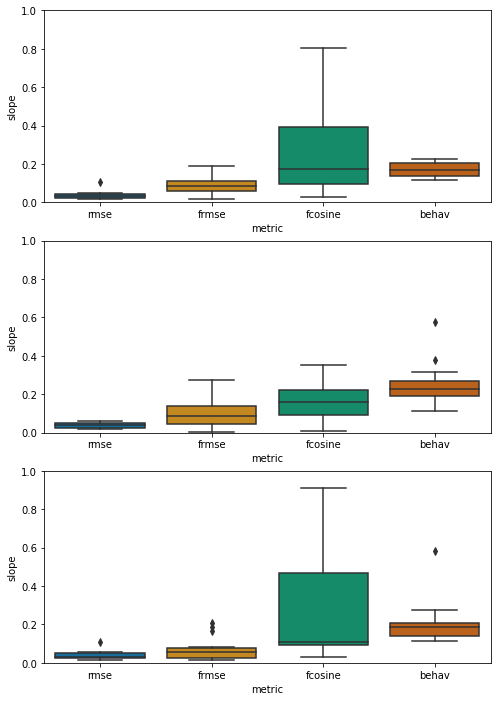

In [94]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
for i, group in enumerate(groups):
    sns.boxplot(y='slope', x='metric',data=all_groups[all_groups.group==group], ax=ax[i])
    ax[i].set_ylim([0,1])

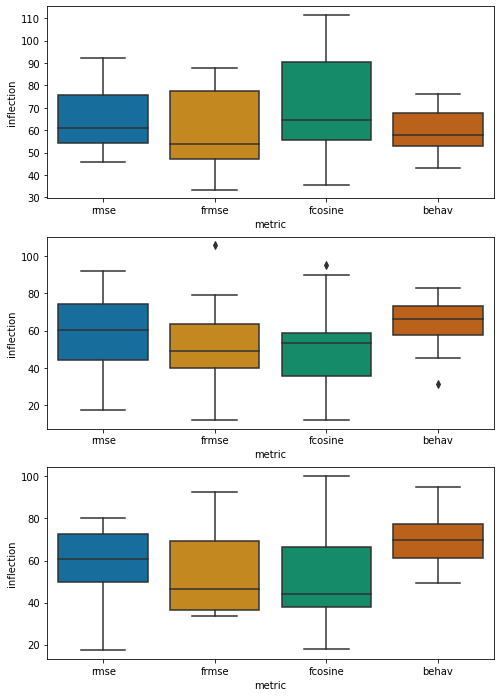

In [95]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
for i, group in enumerate(groups):
    sns.boxplot(y='inflection', x='metric',data=all_groups[all_groups.group==group], ax=ax[i])

In [96]:
import statsmodels.formula.api as smf

In [97]:
all_groups.head()

,index,min_val,max_val,slope,inflection,group,metric
0,af,1.000000e-16,0.958480,0.021558,61.000512,Group 1,rmse
1,ag,1.000000e-16,0.976493,0.029138,52.000103,Group 1,rmse
2,ah,1.500527e-01,0.802789,0.032490,54.001817,Group 1,rmse
3,be,1.535884e-01,1.000000,0.046353,87.584029,Group 1,rmse
4,bf,1.958787e-01,0.981050,0.042703,92.274811,Group 1,rmse


In [98]:
model = smf.mixedlm("slope ~ C(metric, Treatment('behav')) ",
                    all_groups,
                    groups= "group").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
===================================================================================
Model:                      MixedLM          Dependent Variable:          slope    
No. Observations:           186              Method:                      REML     
No. Groups:                 3                Scale:                       2.5437   
Min. group size:            61               Log-Likelihood:              -350.9542
Max. group size:            64               Converged:                   Yes      
Mean group size:            62.0                                                   
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                 0.209    0.232  0.898 0.369 -0.247  0.664
C(metric, Treatment('behav'))[T.fcosine]  0.657    0.329  1.996 0.046  0.012  1.302
C(metric, Treatment('behav'))[T.frmse]   -0.121    0.329 -0.368 0.713 -0.766  0.524
C(metric, Treatment('behav'))[T.rmse]    -0.171    0.329 -0.519 0.604 -0.816  0.474
group Var                                 0.003    0.028                           
===================================================================================

"""

In [99]:
model = smf.mixedlm("inflection ~ C(metric, Treatment('behav')) ",
                    all_groups,
                    groups= "group").fit()

model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
====================================================================================
Model:                      MixedLM          Dependent Variable:          inflection
No. Observations:           186              Method:                      REML      
No. Groups:                 3                Scale:                       383.0198  
Min. group size:            61               Log-Likelihood:              -808.1688 
Max. group size:            64               Converged:                   Yes       
Mean group size:            62.0                                                    
------------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                64.139    3.368 19.046 0.000  57.539 70.739
C(metric, Treatment('behav'))[T.fcosine] -6.549    4.038 -1.622 0.105 -14.464  1.366
C(metric, Treatment('behav'))[T.frmse]   -8.944    4.038 -2.215 0.027 -16.859 -1.029
C(metric, Treatment('behav'))[T.rmse]    -2.960    4.038 -0.733 0.464 -10.875  4.955
group Var                                10.083    0.836                            
====================================================================================

"""

In [100]:
all_groups.tail()

,index,min_val,max_val,slope,inflection,group,metric
181,eh,0.028613,0.944226,0.179967,78.281169,Group 3,behav
182,cf,0.047045,0.882328,0.261025,51.118444,Group 3,behav
183,df,0.054637,0.939378,0.143298,56.879763,Group 3,behav
184,fg,0.079391,0.928413,0.580742,78.445336,Group 3,behav
185,fh,0.063133,0.932895,0.194440,68.749459,Group 3,behav


# compare mean

In [101]:
def subtract_behav(group_behav, item):
    def _subtract_behav(x):
        try:
            return x[item]-group_behav[item][x['index']]
        except:
            return NaN
    return _subtract_behav

In [102]:
normalized_df = pd.DataFrame()
for group in ['Group 1', 'Group 2', 'Group 3']:
    group_df = all_groups[all_groups.group==group].reset_index(drop=True)
    group_behav = group_df[group_df.metric=='behav'][['index', 'slope', 'inflection']].set_index('index').T.to_dict('index')
    group_df['d_slope'] = group_df.apply(lambda x: subtract_behav(group_behav, 'slope')(x), axis=1)
    group_df['d_inflection'] = group_df.apply(lambda x: subtract_behav(group_behav, 'inflection')(x), axis=1)
    normalized_df = pd.concat([normalized_df, group_df]).reset_index(drop=True)

In [103]:
normalized_df

,index,min_val,max_val,slope,inflection,group,metric,d_slope,d_inflection
0,af,1.000000e-16,0.958480,0.021558,61.000512,Group 1,rmse,-0.093799,4.664402
1,ag,1.000000e-16,0.976493,0.029138,52.000103,Group 1,rmse,-0.089629,4.097347
2,ah,1.500527e-01,0.802789,0.032490,54.001817,Group 1,rmse,-0.104190,-14.144366
3,be,1.535884e-01,1.000000,0.046353,87.584029,Group 1,rmse,-0.122110,21.699011
4,bf,1.958787e-01,0.981050,0.042703,92.274811,Group 1,rmse,-0.182019,21.071079
...,...,...,...,...,...,...,...,...,...
181,eh,2.861325e-02,0.944226,0.179967,78.281169,Group 3,behav,0.000000,0.000000
182,cf,4.704466e-02,0.882328,0.261025,51.118444,Group 3,behav,0.000000,0.000000
183,df,5.463681e-02,0.939378,0.143298,56.879763,Group 3,behav,0.000000,0.000000
184,fg,7.939078e-02,0.928413,0.580742,78.445336,Group 3,behav,0.000000,0.000000


In [104]:
normalized_df.groupby('metric')[['d_slope', 'd_inflection']].describe()

d_slope                                                              \
          count      mean       std       min       25%       50%       75%   
metric                                                                        
behav      48.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
fcosine    46.0  0.654041  3.224084 -0.471011 -0.127835 -0.035611  0.075388   
frmse      46.0 -0.123712  0.121359 -0.568291 -0.155191 -0.113867 -0.059305   
rmse       46.0 -0.173324  0.099422 -0.564686 -0.189350 -0.154109 -0.112129   

                   d_inflection                                             \
               max        count      mean        std        min        25%   
metric                                                                       
behav     0.000000         48.0  0.000000   0.000000   0.000000   0.000000   
fcosine  21.237161         46.0 -6.563925  29.548740 -66.353937 -17.539283   
frmse     0.099317         46.0 -8.959324  24.816060 -61.212040 -25.058020   
rmse     -0.061195         46.0 -2.975106  20.208153 -77.227357 -13.988419   

                                        
              50%       75%        max  
metric                                  
behav    0.000000  0.000000   0.000000  
fcosine -8.167044  8.773143  59.987386  
frmse   -8.998849  2.513698  74.733077  
rmse     0.241855  7.182253  46.937914

(-0.5, 1.5)

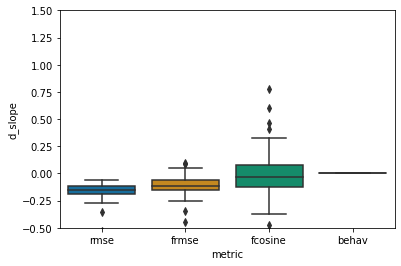

In [106]:
sns.boxplot(x='metric', y='d_slope', data=normalized_df)
plt.ylim([-.5, 1.5])

<AxesSubplot:xlabel='metric', ylabel='d_inflection'>

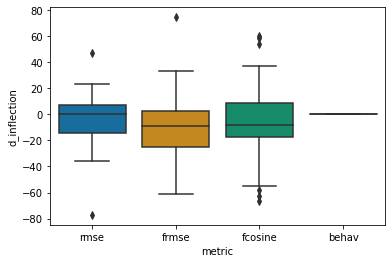

In [108]:
sns.boxplot(x='metric', y='d_inflection', data=normalized_df)
# plt.ylim([-.5, 1.5])